In [29]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import nntools as nt

from pathlib import Path
import json
from matplotlib import patches, patheffects

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# 1. Load database

In [38]:
root_dir = '/datasets/ee285f-public/PascalVOC2012'

In [5]:
PATH = Path(dataset_root_dir)
list(PATH.iterdir())

[PosixPath('/datasets/ee285f-public/PascalVOC2012/.DS_Store'),
 PosixPath('/datasets/ee285f-public/PascalVOC2012/SegmentationClass'),
 PosixPath('/datasets/ee285f-public/PascalVOC2012/SegmentationObject'),
 PosixPath('/datasets/ee285f-public/PascalVOC2012/Annotations'),
 PosixPath('/datasets/ee285f-public/PascalVOC2012/JPEGImages'),
 PosixPath('/datasets/ee285f-public/PascalVOC2012/ImageSets')]

In [52]:
Path().absolute()

PosixPath('/datasets/home/home-02/53/653/w1huang')

In [39]:

img_dir = os.path.join(root_dir, 'JPEGImages')
ann_dir = os.path.join(root_dir, 'Annotations')
set_dir = os.path.join(root_dir, 'ImageSets', 'Main')

In [40]:
set_dir

'/datasets/ee285f-public/PascalVOC2012/ImageSets/Main'

In [42]:
# list image sets
all_files = !ls {set_dir}
image_sets = sorted(list(set([filename.replace('.txt', '').strip().split('_')[0] for filename in all_files])))
print(image_sets) 

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'trainval', 'tvmonitor', 'val']


In [56]:
# with open('pascal_train2012.json') as f:
#     data = json.load(f)
# data
trn_j = json.load((Path().absolute()/'pascal_train2012.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [65]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:3]

[{'file_name': '2008_000008.jpg',
  'height': 442,
  'width': 500,
  'id': 2008000008},
 {'file_name': '2008_000015.jpg',
  'height': 327,
  'width': 500,
  'id': 2008000015},
 {'file_name': '2008_000019.jpg',
  'height': 272,
  'width': 480,
  'id': 2008000019}]

In [62]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[52, 86, 52, 420, 471, 420, 471, 86]],
  'area': 139946,
  'iscrowd': 0,
  'image_id': 2008000008,
  'bbox': [52, 86, 419, 334],
  'category_id': 13,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[157, 43, 157, 167, 289, 167, 289, 43]],
  'area': 16368,
  'iscrowd': 0,
  'image_id': 2008000008,
  'bbox': [157, 43, 132, 124],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [63]:
trn_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

In [64]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

In [79]:
cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]  

In [67]:
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [78]:
trn_fns[2008000008]

'2008_000008.jpg'

In [82]:
trn_ids[1]

2008000015

In [83]:
JPEGS = PATH/'JPEGImages'
list(JPEGS.iterdir())[:5]
list(JPEGS.iterdir())[0]

PosixPath('/datasets/ee285f-public/PascalVOC2012/JPEGImages/2008_000655.jpg')

In [86]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)
trn_anno[2008000008]

[(array([ 86,  52, 419, 470]), 13), (array([ 43, 157, 166, 288]), 15)]

In [87]:
im0_d = trn_j[IMAGES][0]
im0_d

{'file_name': '2008_000008.jpg', 'height': 442, 'width': 500, 'id': 2008000008}

In [88]:
im0_d[FILE_NAME],im0_d[ID]

('2008_000008.jpg', 2008000008)

In [89]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 86,  52, 419, 470]), 13), (array([ 43, 157, 166, 288]), 15)]

In [102]:
im0_a = im_a[0]; im0_a

(array([ 86,  52, 419, 470]), 13)

In [91]:
cats[13],cats[15]

('horse', 'person')

In [92]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [93]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [94]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [95]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [96]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [98]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

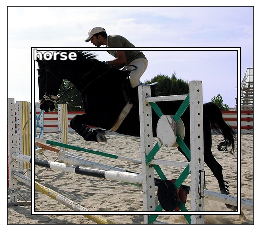

In [104]:
im = Image.open(JPEGS/im0_d[FILE_NAME]).convert('RGB')
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [ ]:
b = bb_hw(im0)